# Enunciado
## Cálculo de la duración de un proyecto usando el Método de Montecarlo

>Considere el proyecto cuya información se adjunta.
> 1. Dibuje el grafo PERT del proyecto.
> 2. Determine las ecuaciones de los tiempos tempranos de cada nodo.
> 3. Calcule, utilizando las ecuaciones, los tiempos tempranos de cada nodo para 1000 iteraciones del método de MonteCarlo.
> 4. Determina la duración media y la desviación típica de la duración del proyecto.
> 5. Determine la duración para una probabilidad de completar antes el proyecto del 98%. 

In [1]:
# Alargamos el ancho de las celdas al 100%
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import pandas as pd
import numpy as np
import matplotlib as plt
%matplotlib notebook

datos_enunciado = pd.DataFrame([
#  actividad, nodo_inicial, nodo_final, duracion media, desviación típica
     ('A',    0,  1,  10, 1.5 ),
     ('B',    0,  2,   5, 0.4 ),  
     ('C',    1,  4,   6, 0.8 ),
     ('D',    1,  3,   2, 0.7 ),
     ('E',    4,  5,   7, 1.8 ), 
     ('F',    3,  5,   8, 0.8 ),
     ('G',    5,  6,   4, 1.4 ),
     ('H',    2,  6,   7, 1.6 ),
     ('f1',   3,  4,   0, 0.0 ),
     ('f2',   2,  3,   0, 0.0 ),
] ,columns=['actividad', 'nodo_inicial', 'nodo_final', 'mean', 'stdev']).set_index('actividad')

datos_enunciado

,nodo_inicial,nodo_final,mean,stdev
actividad,,,,
A,0,1,10,1.5
B,0,2,5,0.4
C,1,4,6,0.8
D,1,3,2,0.7
E,4,5,7,1.8
F,3,5,8,0.8
G,5,6,4,1.4
H,2,6,7,1.6
f1,3,4,0,0.0


## Solución
### Apartado 1
> 1. Dibuje el grafo PERT del proyecto.

In [2]:
from pmule import calcula_encadenamientos, GrafoProyecto

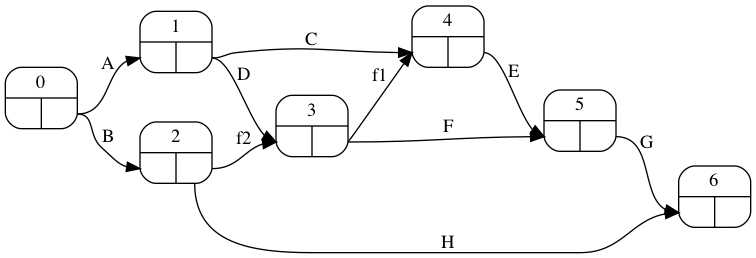

In [3]:
datos_proyecto =  datos_enunciado.copy()
proyecto = GrafoProyecto(datos_proyecto)
proyecto.pert('pert_nodos.png', duraciones=False)

### Apartado 2
> 2. Determine las ecuaciones de los tiempos tempranos de cada nodo.


$t_0 = 0$

$t_1 = t_0 + d_A$

$t_2 = t_0 + d_B$

$ t_3 = \max \begin{Bmatrix} t_1 + d_D \\ t_2 + d_{f_2} \end{Bmatrix} $

$ t_4 = \max \begin{Bmatrix} t_1 + d_C \\ t_2 + d_{f_1} \end{Bmatrix} $

$ t_5 = \max \begin{Bmatrix} t_4 + d_E \\ t_3 + d_F \end{Bmatrix} $

$ t_6 = \max \begin{Bmatrix} t_5+ d_G \\ t_2 + d_H \end{Bmatrix} $


### Apartado 3
> 3. Calcule, utilizando las ecuaciones, los tiempos tempranos de cada nodo para 1000 iteraciones del método de MonteCarlo.

#### Generación aleatoria de las duraciones de las actividades

In [4]:
number_of_samples = 1000

In [5]:
activity_names = datos_proyecto.index
duration = pd.DataFrame([np.random.normal(size = number_of_samples,
                                          loc  = datos_proyecto.loc[task, 'mean',],
                                          scale= datos_proyecto.loc[task, 'stdev'])
                         for task in activity_names
                        ],
                        index=activity_names).T

In [6]:
duration.head()

actividad,A,B,C,D,E,F,G,H,f1,f2
0,12.171836,4.743999,5.049154,1.257821,8.719047,7.125531,3.730921,6.499617,0.0,0.0
1,11.162069,4.832887,7.664723,1.250066,7.366068,8.340296,4.999270,8.669628,0.0,0.0
2,9.746548,5.606154,5.779071,3.044995,8.234846,8.475931,5.107515,7.509325,0.0,0.0
3,10.673642,5.269785,6.190150,1.745493,5.807340,6.496914,2.464215,6.752396,0.0,0.0
4,9.405771,5.029880,6.187731,1.116019,8.705300,9.827064,3.092084,8.603079,0.0,0.0


#### Cálculo de los tiempos tempranos

In [7]:
def row_max(A,B):
    return pd.concat([A,B], axis=1).max(axis=1)

In [8]:
t_early = duration.copy()
t_early.eval("""t_0 = 0

                t_1 = t_0 + A

                t_2 = t_0 + B
                
                input_D = t_1 + D
                input_f2 = t_2+ f2
                t_3 = @row_max(input_D, input_f2)
                
                input_C = t_1 + C
                input_f1 = t_3 + f1
                t_4 = @row_max(input_C, input_f1)

                input_E = t_4 + E 
                input_F = t_3 + F
                t_5 = @row_max(input_E, input_F)

                input_G = t_5 + G
                input_H = t_2 + H
                t_6 = @row_max(input_G, input_H)
                """, inplace=True)

In [9]:
tiempos_nodos = ['t_'+ str(num) for num in range(7)]
t_early.loc[0:10, tiempos_nodos ]

actividad,t_0,t_1,t_2,t_3,t_4,t_5,t_6
0,0,12.171836,4.743999,13.429657,17.220990,25.940036,29.670957
1,0,11.162069,4.832887,12.412135,18.826792,26.192860,31.192130
2,0,9.746548,5.606154,12.791543,15.525620,23.760466,28.867981
3,0,10.673642,5.269785,12.419135,16.863792,22.671131,25.135346
4,0,9.405771,5.029880,10.521791,15.593502,24.298803,27.390887
5,0,10.704052,5.072197,11.956145,16.644031,21.652248,24.138947
6,0,9.023906,4.952314,11.402377,15.768358,20.963190,25.195080
7,0,10.839450,4.300400,13.704894,16.453059,23.397690,27.735485
8,0,10.994525,5.266311,12.240613,17.017148,25.099890,28.850935
9,0,10.377976,5.094612,11.252435,14.931740,21.595296,26.707052


### Apartado 4
> 4. Determina la duración media y la desviación típica de la duración del proyecto.

<IPython.core.display.Javascript object>


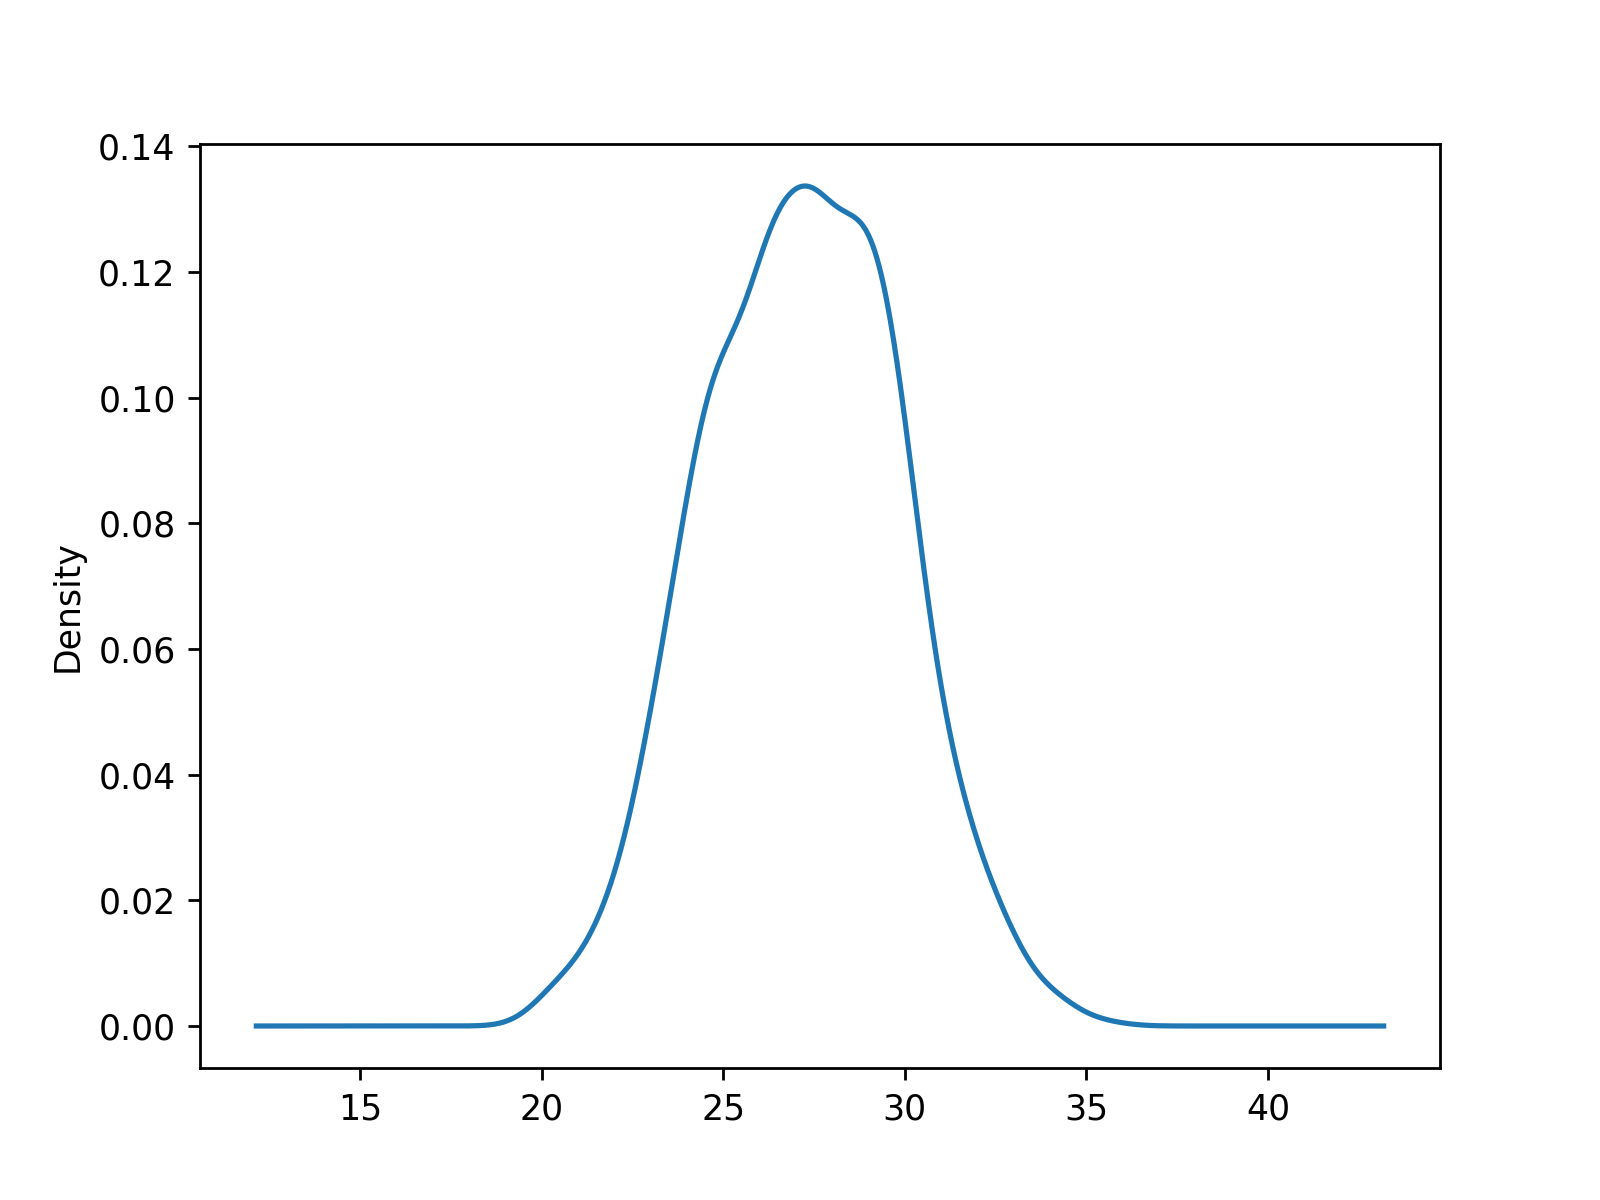

In [10]:
t_early['t_6'].plot(kind='density');

In [11]:
t_early['t_6'].describe()

count    1000.000000
mean       27.171603
std         2.664996
min        19.903076
25%        25.201777
50%        27.250945
75%        29.105800
max        35.425869
Name: t_6, dtype: float64

La duración media del proyecto es:

In [12]:
t_early['t_6'].mean()

27.171603485647168

La desviación típica de la duración del proyecto es:

In [13]:
t_early['t_6'].std()

2.664995951581221

### Apartado 5
> 5. Determine la duración para una probabilidad de completar antes el proyecto del 98%. 

Podemos ordenar los valores en sentido ascendente y quedarnos con aquél valor superior al 98% de las muestras.

In [14]:
t_early['t_6'].sort_values(ascending=True).iloc[int(0.98*number_of_samples)]

32.599380554163346

O bien, utilizando la función `quantile`

In [15]:
t_early['t_6'].quantile(q=0.98, interpolation='higher')

32.599380554163346